# Исследование закономерностей, определяющих успешность игр.

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Описание данных

Name — название игры

Platform — платформа

Year_of_Release — год выпуска

Genre — жанр игры

NA_sales — продажи в Северной Америке (миллионы проданных копий)

EU_sales — продажи в Европе (миллионы проданных копий)

JP_sales — продажи в Японии (миллионы проданных копий)

Other_sales — продажи в других странах (миллионы проданных копий)

Critic_Score — оценка критиков (максимум 100)

User_Score — оценка пользователей (максимум 10)

Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Общая информация о таблице данных. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/games.csv')
display(data.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data.info()
data.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


0

In [4]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

В таблице представленно 11 параметров для каждой игры. Уже в пяти первых строчках видны пропуски данных, а также можно заметить, что не у всех параметров нужный тип данных (например, оценка пользователей - это, скорее всего, должно быть какое-то число). Далее мы рассмотрим все параметры подробнее, выявим пропуски, аномалии и дубликаты.

### Предобратка данных.

Для более удобной дальнейшей работы с таблицей приведем все названия столбоц к нижнему регистру.

In [5]:
data.columns = data.columns.str.lower()
display(data.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Теперь проведем анализ каждого параметра на наличие дубликатов, пропусков и аномалий.

#### Параметр "name".

In [6]:
display(data['name'].nunique())
display(data['name'].unique())

11559

array(['Wii Sports', 'Super Mario Bros.', 'Mario Kart Wii', ...,
       'Woody Woodpecker in Crazy Castle 5', 'LMA Manager 2007',
       'Haitaka no Psychedelica'], dtype=object)

In [7]:
display(data[data['name'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В первом столбце в таблице есть два пропуска. При рассмотрении этих строк подробно, можно сделать вывод, что информация по этим играм в целом не заполнена (в половине столбцов стоит значение "NaN") и их количество составляет малую часть от общего числа данных. Поэтому эти строки удалим из таблицы.

In [8]:
data = data[data.name.notna()]
data.reset_index()
display(data[data['name'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


#### Параметр "platform".

In [9]:
display(data['platform'].unique())

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

По этому параметру пропусков в таблице нет. Неявных дубликатов нет.

#### Параметр "year_of_release".

В столбце "year_of_release", как мы заметили ранее, 269 пропусков. Посмотрим, в каких строчках значения не указаны.

In [10]:
display(data[data['year_of_release'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Это около 2% от общего числа. Такое соотношение позволяет нам удалить эти строки из датафрейма без искажения общей картины данных.

In [11]:
data = data[data.year_of_release.notna()]
data.reset_index()
display(data[data['year_of_release'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


#### Параметр "genre".

In [12]:
display(data['genre'].unique())

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [13]:
display(data[data['genre'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


По этому параметру пропусков и дубликатов нет.

#### Параметр "na_sales".

<AxesSubplot:>

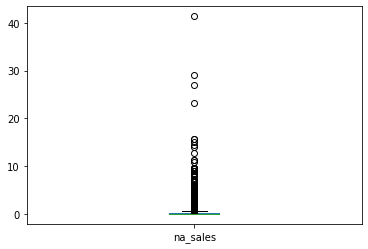

In [14]:
data['na_sales'].plot(kind='box')

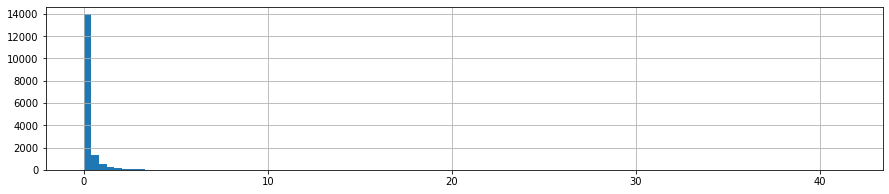

In [15]:
data.na_sales.hist(bins = 100, figsize = (15,3));

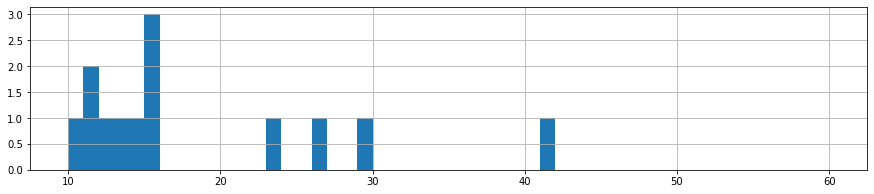

In [16]:
data.na_sales.hist(bins = 50, figsize = (15,3), range=(10, 60));

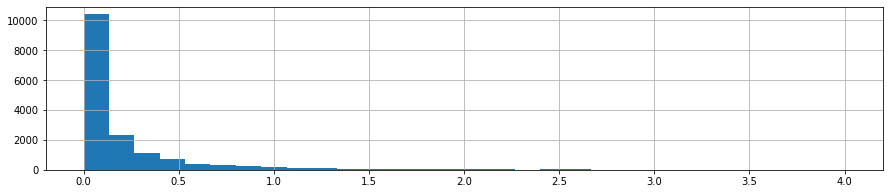

In [17]:
data.na_sales.hist(bins = 30, figsize = (15,3), range=(0, 4));

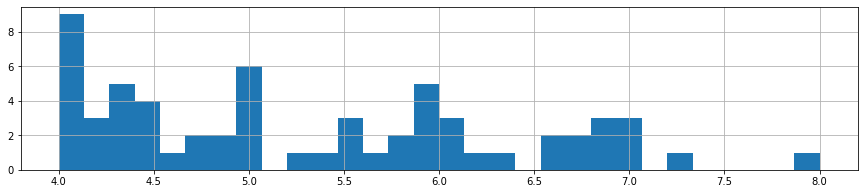

In [18]:
data.na_sales.hist(bins = 30, figsize = (15,3), range=(4, 8));

Здесь мы видим, что основные значения лежат до 4 млн проданных копий. После идут игры с большим количеством проданных копий, но их количество уменьшается до 1 - 10 игры.

In [19]:
display(len(data[data.na_sales > 5]))

59

#### Параметр "eu_sales".

<AxesSubplot:>

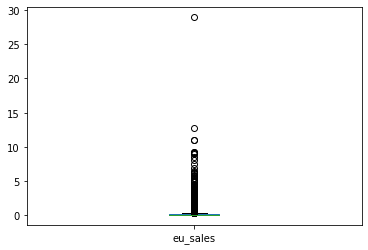

In [20]:
data['eu_sales'].plot(kind='box')

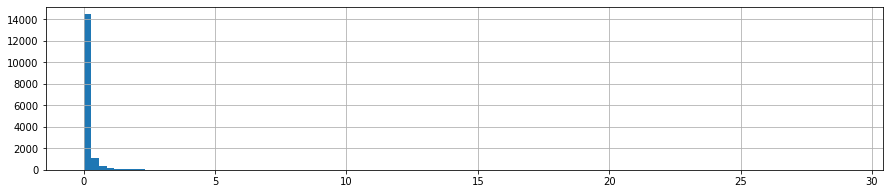

In [21]:
data.eu_sales.hist(bins = 100, figsize = (15,3));

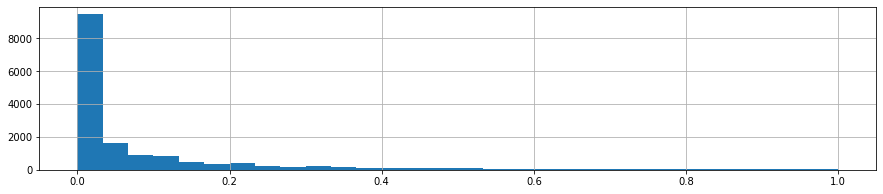

In [22]:
data.eu_sales.hist(bins = 30, figsize = (15,3), range=(0,1));

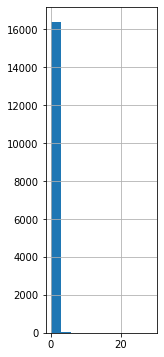

In [23]:
data.eu_sales.hist(bins = 10, figsize = (2,6));

В Европе количество проданный игр меньше. Здесь большая часть игр продается до 1 млн копий.

#### Параметр "jp_sales".

<AxesSubplot:>

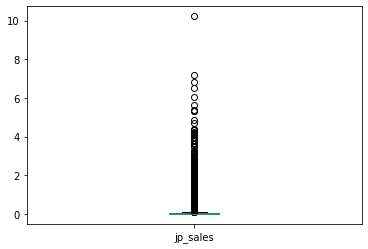

In [24]:
data['jp_sales'].plot(kind='box')

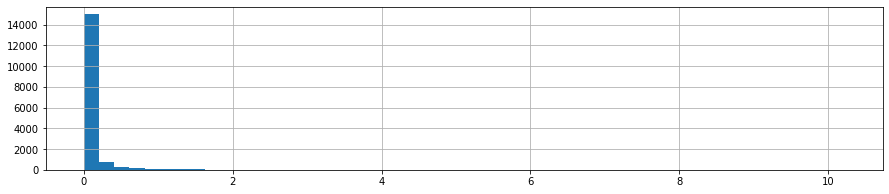

In [25]:
data.jp_sales.hist(bins = 50, figsize = (15,3));

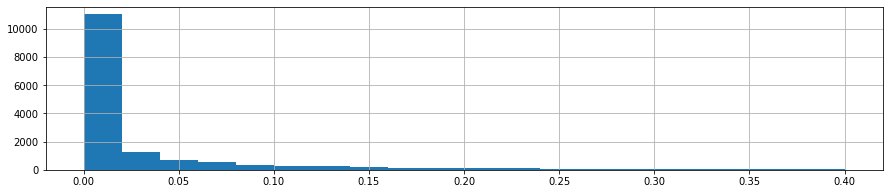

In [26]:
data.jp_sales.hist(bins = 20, figsize = (15,3), range=(0, 0.4));

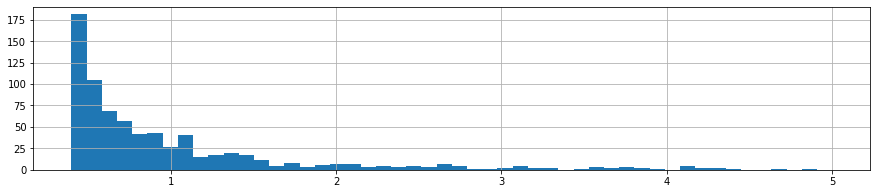

In [27]:
data.jp_sales.hist(bins = 50, figsize = (15,3), range=(0.4, 5));

В Японии игры менее популярны и здесь пик продаж не доходит и до полумиллиона проданных копий.

#### Параметр "other_sales".

<AxesSubplot:>

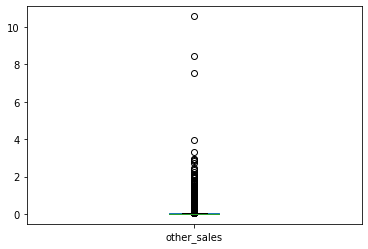

In [28]:
data['other_sales'].plot(kind='box')

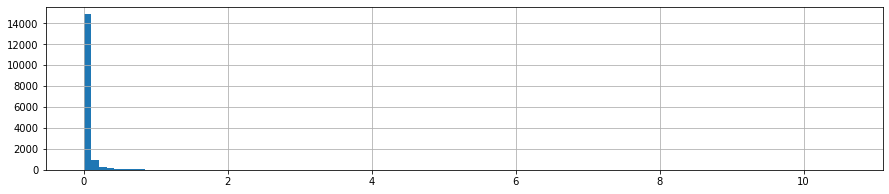

In [29]:
data.other_sales.hist(bins = 100, figsize = (15,3));

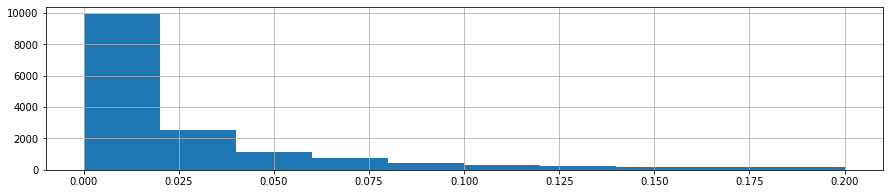

In [30]:
data.other_sales.hist(bins = 10, figsize = (15,3), range=(0, 0.2));

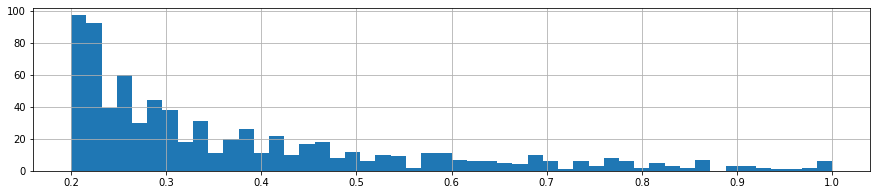

In [31]:
data.other_sales.hist(bins = 50, figsize = (15,3), range=(0.2, 1));

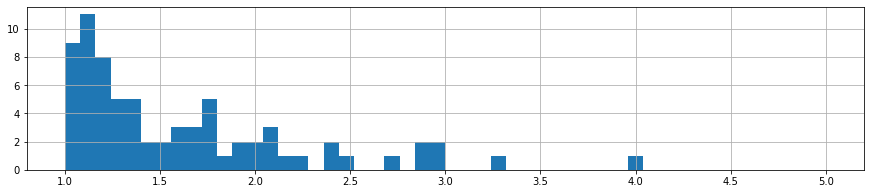

In [32]:
data.other_sales.hist(bins = 50, figsize = (15,3), range=(1, 5));

В других странах видим похожу картину: продажи небольшие. Их пик в остальных странах находит на количестве 200000 проданных копий.

#### Параметр "critic_score".

In [33]:
data.critic_score.value_counts().to_frame()

,critic_score
70.0,252
71.0,248
75.0,240
80.0,235
73.0,234
...,...
29.0,3
20.0,3
13.0,1
17.0,1


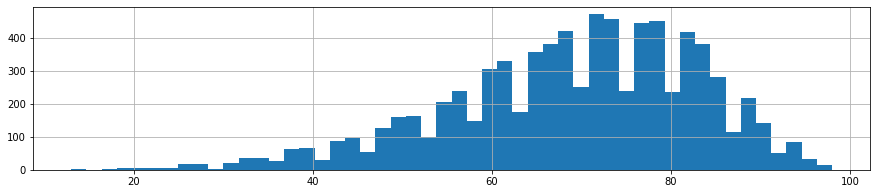

In [34]:
data.critic_score.hist(bins = 50, figsize = (15,3));

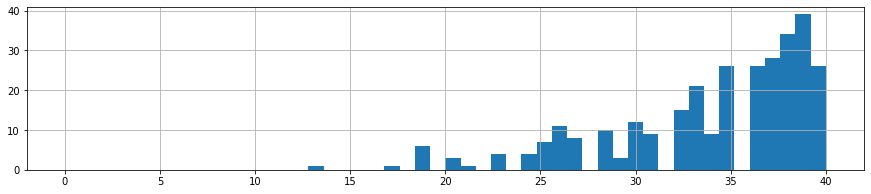

In [35]:
data.critic_score.hist(bins = 50, figsize = (15,3), range=(0, 40));

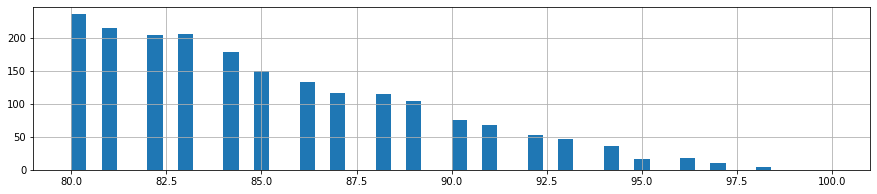

In [36]:
data.critic_score.hist(bins = 50, figsize = (15,3), range=(80, 100));

Можно заметить, что игры очень редко набирают оценку ниже 30 и выше 93 баллов. Основная проблема заключается в том, что в этом параметре очень много пропусков (около 50% игр без оценки критиков)

In [37]:
display(data[data['critic_score'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [38]:
display(data[(data['critic_score'].isna()) & (data['user_score'].isna())])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [39]:
display(data[(data['critic_score'].isna()) & (data['user_score'].isna()) & (data['rating'].isna())])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Появляется проблемма в датафрейме. В параметрах "critic_score", "rating", "user_score" в 6000 играх не проставлена оценка. Это очень большая дыра в данных, чтобы поставить здесь медианные значения или удалить их из таблицы. Также можно заметить, что у некоторых таких игр продажи копий не принимали значения больше миллиона, хотя бы в одной категории стран. Проверим теорию, что рейтинг не выставлен у игр, которых мало купили и, скорее всего, по этой причине не получилось проанализировать какую-либо оценку.

In [40]:
display(data
        .query(
            'critic_score.isna() & user_score.isna() & rating.isna() & \
            ((na_sales < 0.1) | (eu_sales < 0.1) | (jp_sales < 0.1) | (other_sales < 0.1))'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
72,Minecraft,X360,2013.0,Misc,5.70,2.65,0.02,0.81,NaN,NaN,NaN
89,Pac-Man,2600,1982.0,Puzzle,7.28,0.45,0.00,0.08,NaN,NaN,NaN
99,Call of Duty: Black Ops 3,XOne,2015.0,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,NaN
158,Super Smash Bros.,N64,1999.0,Fighting,2.95,0.60,1.97,0.04,NaN,NaN,NaN
168,Pokemon Stadium,N64,1999.0,Strategy,3.18,1.24,0.94,0.09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Теория подтверждается. Для общей картины добавим столбец "total_sales", чтобы понять действительно ли количество продаж и рейтинг связаны.

In [41]:
data['total_sales'] = data['na_sales'] + data['jp_sales'] + data['eu_sales'] + data['other_sales']
display(data[(data['critic_score'].isna()) & (data['user_score'].isna()) & (data['rating'].isna())])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,24.67
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


In [42]:
data_nan_score = data[(data['critic_score'].isna()) & (data['user_score'].isna()) & (data['rating'].isna())]
display(data_nan_score['total_sales'].describe())

count    6534.000000
mean        0.428549
std         1.377091
min         0.000000
25%         0.040000
50%         0.110000
75%         0.340000
max        40.240000
Name: total_sales, dtype: float64

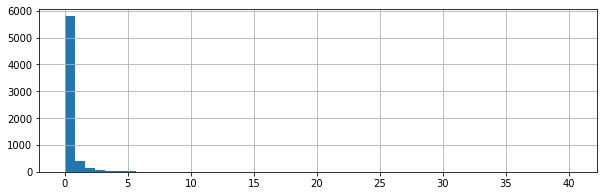

In [43]:
data_nan_score.total_sales.hist(bins = 50, figsize = (10,3));

6000 строк из почти 17000 начальных с играми без рейтинга, при этом большинство таких игр в сумме по всем странам не превышают 1млн проданных копий. Эти данные нельзя заменить, а также удалить. Оставим их в таблице.

#### Параметр "user_score".

In [44]:
data.user_score.value_counts().to_frame()

,user_score
tbd,2376
7.8,322
8,285
8.2,276
8.3,252
...,...
0.9,2
1,2
0.5,2
0,1


В параметре 'user_score' стоит значение 'tbd', что означает 'To Be Determined' или 'будет определенно'. Для нас - это просто "NaN". Поэтому сделаем замену во всех строчках со значением 'tbd'

In [45]:
data['user_score'] = data['user_score'].replace('tbd', float('NaN'))
data['user_score'] = data['user_score'].astype('float64')
data.user_score.value_counts().to_frame()

,user_score
7.8,322
8.0,285
8.2,276
8.3,252
7.5,249
...,...
2.3,2
0.7,2
1.1,2
9.7,1


In [46]:
data_nan_score = data[(data['critic_score'].isna()) & (data['user_score'].isna()) & (data['rating'].isna())]
display(data_nan_score['total_sales'].describe())

count    6580.000000
mean        0.426193
std         1.372613
min         0.000000
25%         0.040000
50%         0.110000
75%         0.340000
max        40.240000
Name: total_sales, dtype: float64

#### Параметр "rating".

In [47]:
data.rating.value_counts().to_frame()

,rating
E,3921
T,2905
M,1536
E10+,1393
EC,8
K-A,3
AO,1
RP,1


In [48]:
data['rating'].describe()

count     9768
unique       8
top          E
freq      3921
Name: rating, dtype: object

Заменим пропуски в параметре rating на значение 'unknown'

In [49]:
data.loc[data['rating'].isna(), 'rating'] = 'unknown'
data.rating.value_counts().to_frame()

,rating
unknown,6676
E,3921
T,2905
M,1536
E10+,1393
EC,8
K-A,3
AO,1
RP,1


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.6+ MB


#### Заключение.

Что было сделано с данными: все данные переведены в более подходящий тип данных, изменены названия стобцов, а также была проведена работа с пропусками. Там, где было возможно, пропуски были убраны, в половине случаев (в параметрах, связанных с оценками) - пропуски, скорее всего, были связаны с малым количеством проданных копий по всему миру. Такие игры будут отдельно учитываться при дальнейшем поиске закономерностей, определяющих успешность игры. Полностью избавиться от них и не исказить картину мы не можем.

In [51]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
name : кол-

### Исследовательский анализ данных.

#### Выпуск игр в разные годы.

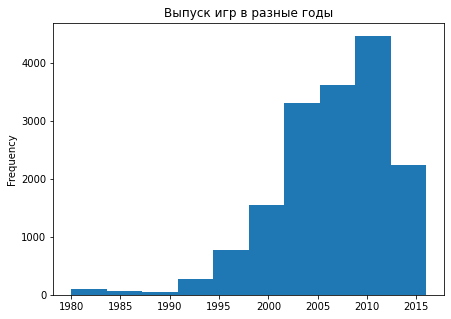

In [52]:
#data.year_of_release.hist(bins = 30, figsize = (15,3), legend='Выпуск игр в разные годы');
data.year_of_release.plot(kind='hist', title='Выпуск игр в разные годы', figsize=(7,5));

In [53]:
data.year_of_release.value_counts().to_frame()

,year_of_release
2008.0,1427
2009.0,1426
2010.0,1255
2007.0,1197
2011.0,1136
2006.0,1006
2005.0,939
2002.0,829
2003.0,775
2004.0,762


До 1995 года количество выпускаемых игр в год не превышало 200 штук. После 2000 года виден заметный рост. Пик был в 2008 - 2010 годах.

#### Продажи по платформам.

In [54]:
sales_platform = data.pivot_table(index='platform', values='total_sales')

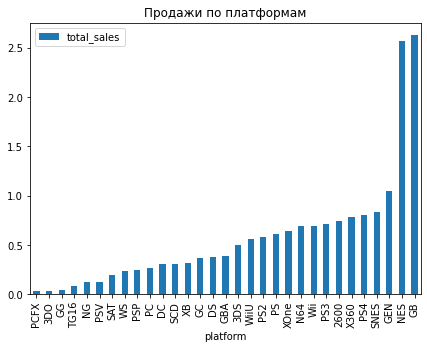

In [55]:
sales_platform.sort_values(by='total_sales').plot(kind='bar',figsize=(7,5), title='Продажи по платформам');

По побщему количеству продаж выделяются 8 платформ: 'XOne', 'PS', 'N64', 'X360', 'GB', '2600', 'GEN', 'NES'. Рассмотрим, какие показатели были с 2011 года по 2016 год. Это промежуток будем считать актуальным для нашего анализа.

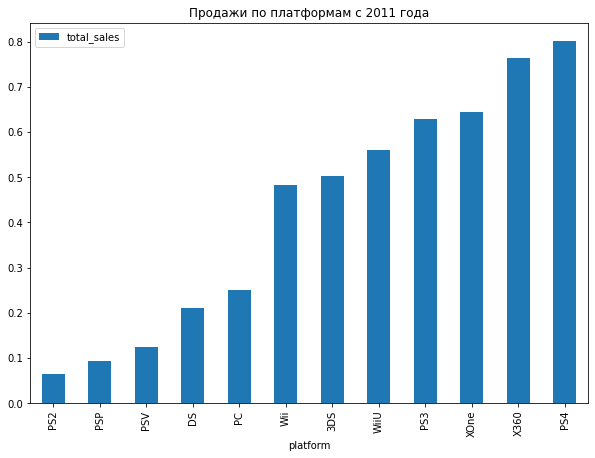

In [56]:
data_actualy_year = data.query('year_of_release >= 2011')
sales_platform = data_actualy_year.pivot_table(index='platform', values='total_sales')
sales_platform.sort_values(by='total_sales').plot(kind='bar',figsize=(10,7), title='Продажи по платформам с 2011 года');

Здесь лидеры продаж меняются, поэтому выделим 5 платформ с наибольшими показателями. Это 'PS4', 'X360', 'XOne', 'PS3', 'WiiU'.

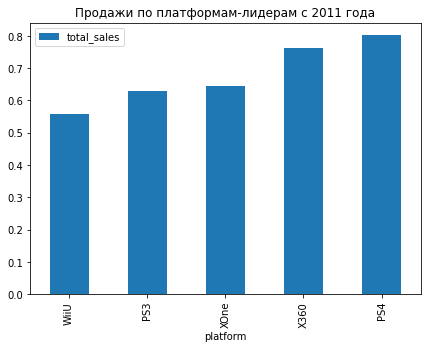

In [57]:
big_platform = [ 'PS4', 'X360', 'XOne', 'PS3', 'WiiU']
data_actualy_platform = data_actualy_year.query('platform in @big_platform')
sales_platform = data_actualy_platform.pivot_table(index='platform', values='total_sales')
sales_platform.sort_values(by='total_sales').plot(kind='bar',figsize=(7,5), title='Продажи по платформам-лидерам с 2011 года');

Таким образом мы выделили актуальный период (это игры, выпущенные после 2011 года) и потенциально прибыльные платформы.

*Разделила данные на две части: есть данные, отфильтрованные только по актуальному периоду, и данные, отфильтрованные по актуальному периоду и платформам

#### Глобальные продажи игр в разбивке по платформам. "Ящик с усами".

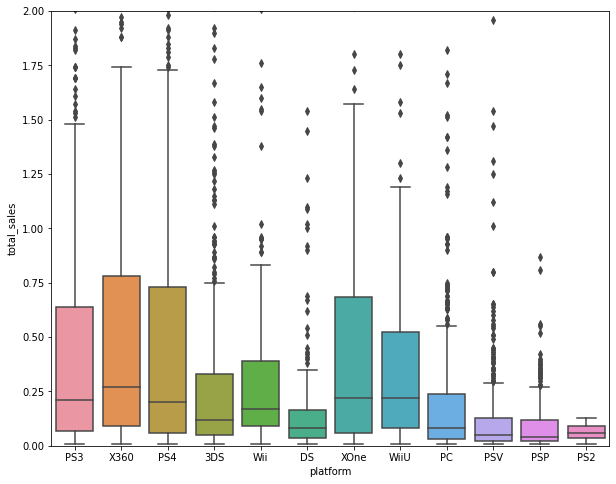

In [58]:
plt.figure(figsize=(10,8))
plt.ylim(0,2)
sns.boxplot(x='platform', y='total_sales', data=data_actualy_year);

Рассмотрим общую картину по всем платформам. Платформы - лидеры, которые мы выделили ранее, между собой в целом схожи. Медианное значение находится примерно на одном уровне около 250000 проданных копий. Самый большой "ящик" у платформы X360. У остальных платформ медианное значение ниже. Но при этом у всех платформ смещение происходит в правую сторону.

#### Влияние оценок на продажи внутри платформы X360.

По общему количеству проданных экземпляров игра X360 является лидером.

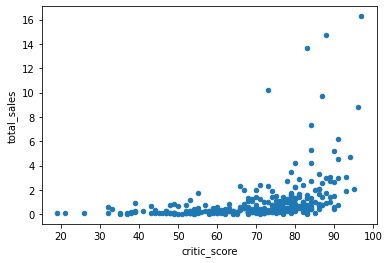

In [59]:
data_x360 = data_actualy_year[data_actualy_year['platform'] == 'X360']
data_x360.plot(y='total_sales', x='critic_score', kind='scatter');

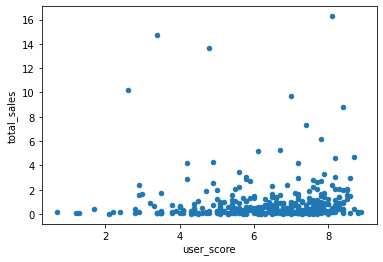

In [60]:
data_x360.plot(y='total_sales', x='user_score', kind='scatter');

In [61]:
data_x360[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.391253,0.038918
critic_score,0.391253,1.000000,0.568386
user_score,0.038918,0.568386,1.000000


Прослеживается положительная средняя корреляция между общими продажами и оценкой критиков, общими продажами и оценкой пользователей. Во втором случае - взаимосвязь слабая.

#### Влияние оценок на продажи внутри платформы PS4.

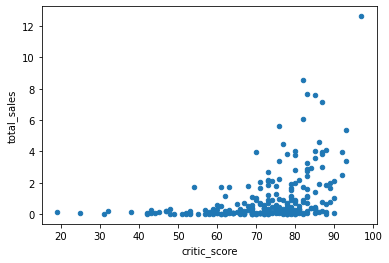

In [62]:
data_ps4 = data_actualy_year[data_actualy_year['platform'] == 'PS4']
data_ps4.plot(y='total_sales', x='critic_score', kind='scatter');

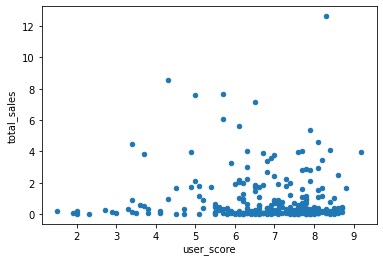

In [63]:
data_ps4.plot(y='total_sales', x='user_score', kind='scatter');

In [64]:
data_ps4[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


В отличие от платформы X360 у платформы PS4 есть отличие в взаимосвязи общих продаж и оценок пользователей. Здесь прослеживается отрицательная слабая корреляция, что означает: увеличение проданных копий связано с уменьшением оценки пользователей. При этом связь общих продаж и оценки критиков примерно одинаковая у двух платформ.

#### Влияние оценок на продажи внутри платформы XOne.

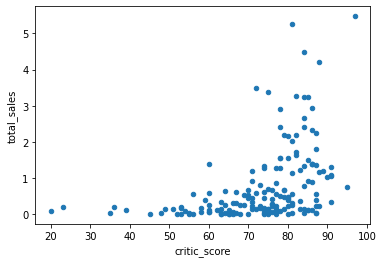

In [65]:
data_xone = data_actualy_year[data_actualy_year['platform'] == 'XOne']
data_xone.plot(y='total_sales', x='critic_score', kind='scatter');

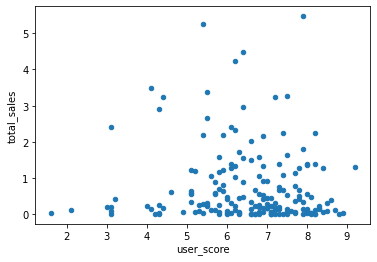

In [66]:
data_xone.plot(y='total_sales', x='user_score', kind='scatter');

In [67]:
data_xone[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


Прослеживается аналогичная ситуация влияния оценок продаж, как и у платформы PS4.

#### Влияние оценок на продажи внутри платформы PS3.

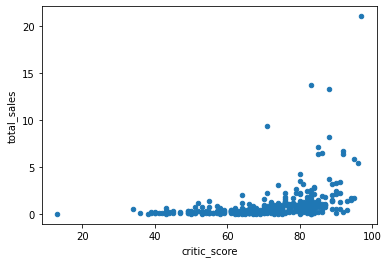

In [68]:
data_ps3 = data_actualy_year[data_actualy_year['platform'] == 'PS3']
data_ps3.plot(y='total_sales', x='critic_score', kind='scatter');

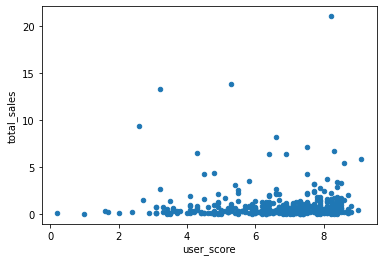

In [69]:
data_ps3.plot(y='total_sales', x='user_score', kind='scatter');

In [70]:
data_ps3[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.380111,0.014089
critic_score,0.380111,1.000000,0.563315
user_score,0.014089,0.563315,1.000000


Здесь влияние больше походит на платформу X360, только взаимосвязь общих продаж и оценки пользователей на данной платформе еще слабее.

#### Влияние оценок на продажи внутри платформы WiiU.

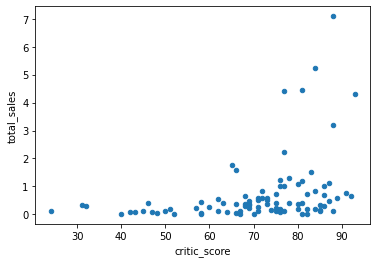

In [71]:
data_wiiu = data_actualy_year[data_actualy_year['platform'] == 'WiiU']
data_wiiu.plot(y='total_sales', x='critic_score', kind='scatter');

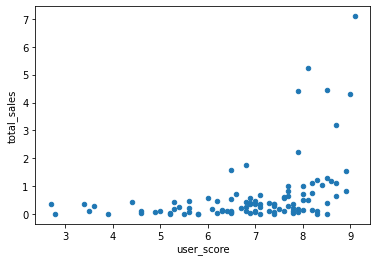

In [72]:
data_wiiu.plot(y='total_sales', x='user_score', kind='scatter');

In [73]:
data_wiiu[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.34838,0.400219
critic_score,0.348380,1.00000,0.770080
user_score,0.400219,0.77008,1.000000


Прослеживается аналогичная ситуация влияния оценок продаж, как и у платформ X360, PS3. Отличие: взаимосвязь продаж и оценок пользователей здесь сильнее. 

В качестве анализа влияния оценок на продажи было рассмотрено 5 лидирующих платформ. Однозначно можно сказать, что прослеживается положительная средняя (или близкая с сильной) связь между количеством продаж и оценкой критиков. А вот с оценкой пользователей все не так одинаково: где-то эта связь отрицательная (то есть количество проданных копий влияет на уменьшение оценки), где-то положительная (обратная ситуация), а также есть платформы, где эта связь слабая.

#### Распределение игр по жанрам.

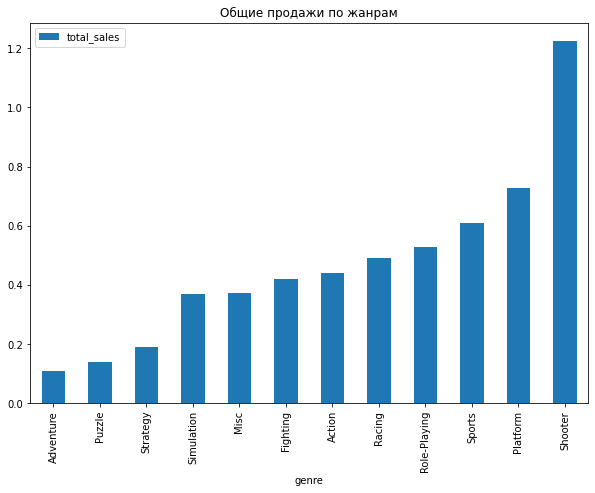

In [74]:
data_genre = data_actualy_year.pivot_table(index='genre', values='total_sales')
data_genre.sort_values(by='total_sales').plot(kind='bar',figsize=(10,7), title='Общие продажи по жанрам');

Выделяются 3 самых популярных жанра: Shooter, Platform, Sports. Самые низкие продажи у жанра Adventure. Это общая картина по всем платформам. Рассмотрим медианные продажи.

genre
Action          0.130
Adventure       0.030
Fighting        0.180
Misc            0.130
Platform        0.185
Puzzle          0.050
Racing          0.160
Role-Playing    0.150
Shooter         0.410
Simulation      0.110
Sports          0.200
Strategy        0.080
Name: total_sales, dtype: float64

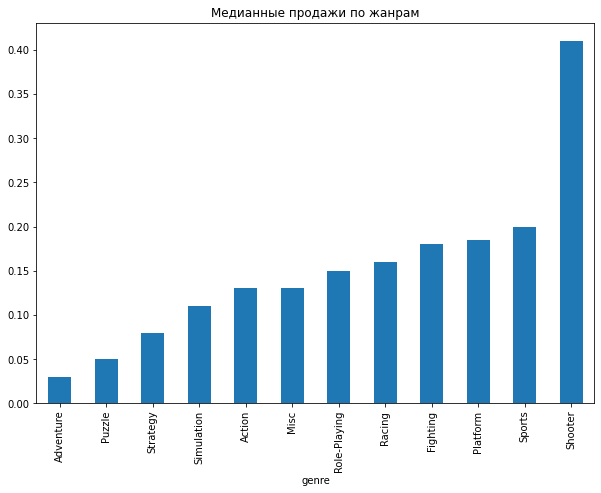

In [75]:
median_data_genre = data_actualy_year.groupby('genre')['total_sales'].median()
display(median_data_genre)
median_data_genre.sort_values().plot(kind='bar', figsize=(10,7), title='Медианные продажи по жанрам');

Лидером по продажам является жанр Shooter. Заканчивает список жанр Adventure.

Топ-список по самым популярным жанрам: Shooter, Sports, Platform, Fighting, Racing.

### Портрет пользователя каждого региона.

#### NA.

Данные будем анализировать по актуальному периоду (с 2011 года), по платформам-лидерам (топ-5),жанрам-лидерам (топ-5) и рейтингу ESRB.

In [76]:
data_na_sales = data_actualy_year.pivot_table(index='platform',values=['na_sales','total_sales'],aggfunc=('sum'))
data_na_sales['share'] = round(data_na_sales['na_sales'] / data_na_sales['total_sales'] * 100, 2)
data_na_sales = data_na_sales.sort_values(by='na_sales', ascending=False)
display(data_na_sales)

,na_sales,total_sales,share
platform,,,
X360,226.80,380.38,59.62
PS3,168.26,445.57,37.76
PS4,108.74,314.14,34.62
XOne,93.12,159.32,58.45
3DS,82.65,257.81,32.06
Wii,48.56,95.02,51.11
WiiU,38.10,82.19,46.36
PC,29.88,97.68,30.59
DS,18.86,38.73,48.70


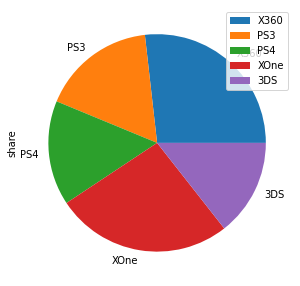

In [77]:
data_na_sales[:5].plot(kind='pie',y="share", figsize=(5, 5));

По количеству проданных игр в Северной Америке является платформа X360, при этом продажи составляют 60% от продаж по всему миру. По этому параметру X360 обгоняет только платформа Wii с долей в 51% от общих продаж, но в том-платформ по Северной Америке не входит.

In [78]:
data_na_genre = data_actualy_year.pivot_table(index='genre', values=['na_sales'], aggfunc=('sum'))
data_na_genre = data_na_genre.sort_values(by='na_sales', ascending=False)
display(data_na_genre)

,na_sales
genre,
Action,230.92
Shooter,194.43
Sports,108.70
Role-Playing,83.78
Misc,69.69
Platform,38.28
Racing,31.98
Fighting,31.63
Simulation,15.37


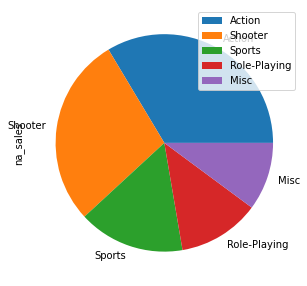

In [79]:
data_na_genre[:5].plot(kind='pie',y="na_sales", figsize=(5, 5));

В Северной америке самым популярным жанром является жанр Action. После него идут Shooter и Sports.

In [80]:
data_na_esrb = data_actualy_year.pivot_table(index='rating',values=['na_sales'],aggfunc=('sum'))
data_na_esrb = data_na_esrb.sort_values(by='na_sales',ascending=False)
display(data_na_esrb)

,na_sales
rating,
M,308.45
E,170.17
unknown,123.69
E10+,117.72
T,109.31
EC,0.42
RP,0.00


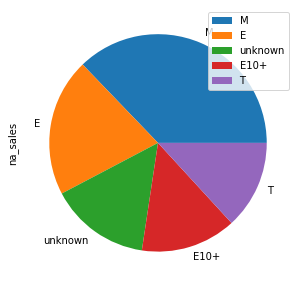

In [81]:
data_na_esrb[:5].plot(kind='pie',y="na_sales", figsize=(5, 5));

По рейтингу ESRB в Северной Америке в большой степени продавались игры с возрастными ограничениями 17+, 6+ и 10+. Посмотрим, будут ли такие же показател продаж игр в других регионах или рейтинг влияет на отедльные регионы по-разному.

#### EU.

In [82]:
data_eu_sales = data_actualy_year.pivot_table(index='platform',values=['eu_sales','total_sales'],aggfunc=('sum'))
data_eu_sales['share'] = round(data_eu_sales['eu_sales'] / data_eu_sales['total_sales'] * 100, 2)
data_eu_sales = data_eu_sales.sort_values(by='eu_sales', ascending=False)
display(data_eu_sales)

,eu_sales,total_sales,share
platform,,,
PS3,163.10,445.57,36.60
PS4,141.09,314.14,44.91
X360,117.10,380.38,30.79
3DS,61.27,257.81,23.77
PC,56.70,97.68,58.05
XOne,51.59,159.32,32.38
Wii,29.60,95.02,31.15
WiiU,25.13,82.19,30.58
PSV,13.07,53.81,24.29


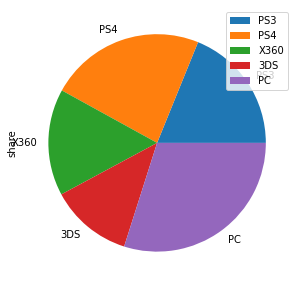

In [83]:
data_eu_sales[:5].plot(kind='pie',y="share", figsize=(5, 5));

По количеству проданных игр в Европе является платформа PS3, при этом продажи составляют 37% от продаж по всему миру. По этому параметру PS3 обгоняет только платформа PC с долей в 58% от общих продаж.

In [84]:
data_eu_genre = data_actualy_year.pivot_table(index='genre', values=['eu_sales'], aggfunc=('sum'))
data_eu_genre = data_eu_genre.sort_values(by='eu_sales', ascending=False)
display(data_eu_genre)

,eu_sales
genre,
Action,199.12
Shooter,148.02
Sports,88.48
Role-Playing,62.30
Racing,40.58
Misc,39.72
Platform,30.07
Simulation,19.72
Fighting,16.24


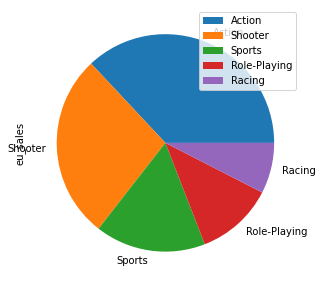

In [85]:
data_eu_genre[:5].plot(kind='pie',y="eu_sales", figsize=(5, 5));

В Европе самым популярным жанром является жанр Action. После него идут Sports и Shooter.

In [86]:
data_eu_esrb = data_actualy_year.pivot_table(index='rating',values=['eu_sales'],aggfunc=('sum'))
data_eu_esrb = data_eu_esrb.sort_values(by='eu_sales',ascending=False)
display(data_eu_esrb)

,eu_sales
rating,
M,250.26
E,141.73
unknown,116.61
T,83.16
E10+,78.00
RP,0.03
EC,0.00


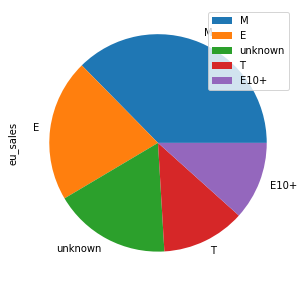

In [87]:
data_eu_esrb[:5].plot(kind='pie',y="eu_sales", figsize=(5, 5));

Здесь лидером также является рейтинг М с возрастным ограничением 17+, но в тройку также входит рейтинг Т, в отличие от Северной Америки.

#### JP.

In [88]:
data_jp_sales = data_actualy_year.pivot_table(index='platform',values=['jp_sales','total_sales'],aggfunc=('sum'))
data_jp_sales['share'] = round(data_jp_sales['jp_sales'] / data_jp_sales['total_sales'] * 100, 2)
data_jp_sales = data_jp_sales.sort_values(by='jp_sales', ascending=False)
display(data_jp_sales)

,jp_sales,total_sales,share
platform,,,
3DS,100.62,257.81,39.03
PS3,49.39,445.57,11.08
PSP,24.04,29.01,82.87
PSV,21.84,53.81,40.59
PS4,15.96,314.14,5.08
WiiU,13.01,82.19,15.83
Wii,8.97,95.02,9.44
DS,8.04,38.73,20.76
X360,3.35,380.38,0.88


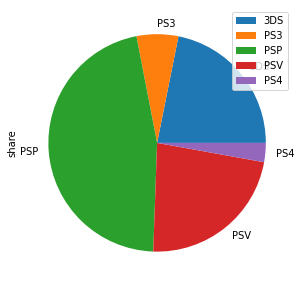

In [89]:
data_jp_sales[:5].plot(kind='pie',y="share", figsize=(5, 5));

По количеству проданных игр в Японии является платформа 3DS, при этом продажи составляют 39% от продаж по всему миру.

In [90]:
data_jp_genre = data_actualy_year.pivot_table(index='genre', values=['jp_sales'], aggfunc=('sum'))
data_jp_genre = data_jp_genre.sort_values(by='jp_sales', ascending=False)
display(data_jp_genre)

,jp_sales
genre,
Role-Playing,79.87
Action,63.62
Misc,17.60
Fighting,12.38
Platform,12.13
Adventure,12.07
Shooter,11.92
Simulation,11.64
Sports,11.09


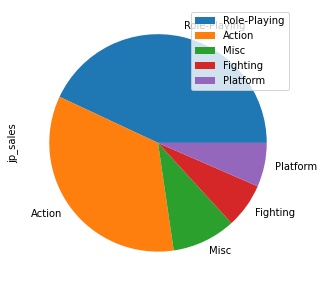

In [91]:
data_jp_genre[:5].plot(kind='pie',y="jp_sales", figsize=(5, 5));

В Японии самым популярным жанром является жанр Role-Playing. После него идут Action и Misc.

In [92]:
data_jp_esrb = data_actualy_year.pivot_table(index='rating',values=['jp_sales'],aggfunc=('sum'))
data_jp_esrb = data_jp_esrb.sort_values(by='jp_sales',ascending=False)
display(data_jp_esrb)

,jp_sales
rating,
unknown,138.21
E,36.68
T,33.39
M,26.14
E10+,11.23
EC,0.00
RP,0.00


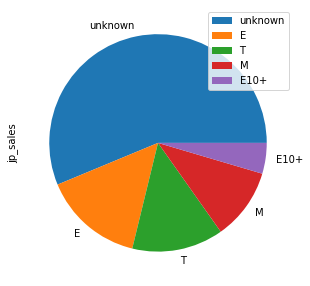

In [93]:
data_jp_esrb[:5].plot(kind='pie',y="jp_sales", figsize=(5, 5));

Здесь тройка лидеров похожа на европейскую, но распределение отличается. Лидерами являются игры с рейтингом E.

#### Other country.

In [94]:
data_other_sales = data_actualy_year.pivot_table(index='platform',values=['other_sales','total_sales'],aggfunc=('sum'))
data_other_sales['share'] = round(data_other_sales['other_sales'] / data_other_sales['total_sales'] * 100, 2)
data_other_sales = data_other_sales.sort_values(by='other_sales', ascending=False)
display(data_other_sales)


,other_sales,total_sales,share
platform,,,
PS3,64.82,445.57,14.55
PS4,48.35,314.14,15.39
X360,33.13,380.38,8.71
XOne,14.27,159.32,8.96
3DS,13.27,257.81,5.15
PC,11.10,97.68,11.36
Wii,7.89,95.02,8.30
PSV,6.43,53.81,11.95
WiiU,5.95,82.19,7.24


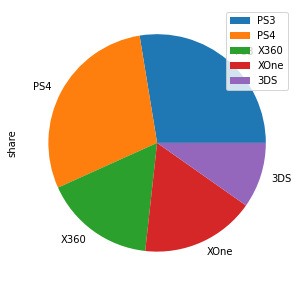

In [95]:
data_other_sales[:5].plot(kind='pie',y="share", figsize=(5, 5));

По количеству проданных игр в других странах является платформа PS3, при этом продажи составляют 15%.

In [96]:
data_other_genre = data_actualy_year.pivot_table(index='genre', values=['other_sales'], aggfunc=('sum'))
data_other_genre = data_other_genre.sort_values(by='other_sales', ascending=False)
display(data_other_genre)

,other_sales
genre,
Action,64.14
Shooter,48.54
Sports,28.88
Role-Playing,19.68
Misc,12.41
Racing,10.11
Platform,8.20
Fighting,6.65
Adventure,4.25


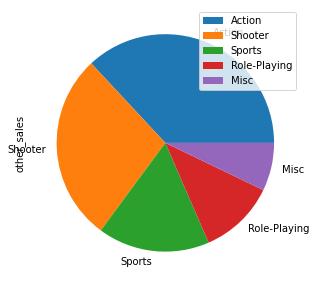

In [97]:
data_other_genre[:5].plot(kind='pie',y="other_sales", figsize=(5, 5));

В других странах самым популярным жанром является жанр Action. После него идут Sports и Shooter.

In [98]:
data_other_esrb = data_actualy_year.pivot_table(index='rating',values=['other_sales'],aggfunc=('sum'))
data_other_esrb = data_other_esrb.sort_values(by='other_sales',ascending=False)
display(data_other_esrb)

,other_sales
rating,
M,81.96
E,40.86
unknown,33.97
T,28.17
E10+,23.91
EC,0.03
RP,0.01


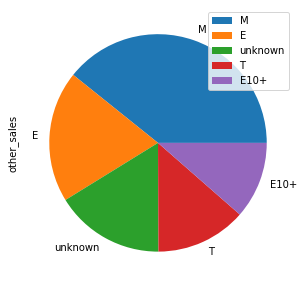

In [99]:
data_other_esrb[:5].plot(kind='pie',y="other_sales", figsize=(5, 5));

Здесь также являются лидерами продаж игры с рейтингом М. В тройке находятся рейтинги Е и Т.

### Построение и проверка гипотез.

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Проверка гипотезы: cредние пользовательские рейтинги платформ Xbox One и PC одинаковые;

```
H_0: cредние пользовательские рейтинги платформ Xbox One = cредние пользовательские рейтинги платформ PC`
H_1: cредние пользовательские рейтинги платформ Xbox One ≠ cредние пользовательские рейтинги платформ PC`
alpha = 0.05
```

In [100]:
data_0 = data.query('year_of_release >= 2008')

In [101]:
xbox_user = data_0.loc[(data_0['platform'] == 'XOne') & (data['user_score'].notna())]['user_score']
pc_user = data_0.loc[(data_0['platform'] == 'PC') & (data['user_score'].notna())]['user_score']
results = st.ttest_ind(xbox_user, pc_user, equal_var=False)
alpha = 0.05
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Средний пользовательский рейтинг платформы Xbox One:', xbox_user.mean())
print('Средний пользовательский рейтинг платформы PC', pc_user.mean())

0.11111296036738474
Не получилось отвергнуть нулевую гипотезу
Средний пользовательский рейтинг платформы Xbox One: 6.521428571428572
Средний пользовательский рейтинг платформы PC 6.71747572815534


#### Средние пользовательские рейтинги жанров Action и Sports разные.

Проверка гипотезы: cредние пользовательские рейтинги жанров Action и Sports разные;

```
H_0: cредние пользовательские рейтинги жанра Action = cредние пользовательские рейтинги жанра Sports`
H_1: cредние пользовательские рейтинги жанра Action ≠ cредние пользовательские рейтинги жанра Sports`
alpha = 0.05
```

In [102]:
action = data_0.loc[(data_0['genre'] == 'Action') & (data['user_score'].notna())]['user_score']
sports = data_0.loc[(data_0['genre'] == 'Sports') & (data['user_score'].notna())]['user_score']
results = st.ttest_ind(action, sports, equal_var=False)
alpha = 0.05
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Средний пользовательский рейтинг жанра Action:', action.mean())
print('Средний пользовательский рейтинг жанра Sports', sports.mean())

4.910932152133621e-13
Отвергаем нулевую гипотезу
Средний пользовательский рейтинг жанра Action: 6.854444444444444
Средний пользовательский рейтинг жанра Sports 6.215863453815261


#### Заключение

Необходимо было проверить две гипотезы. Для этого были сформулированы нулевая и альтернативная двустрононняя гипотезы. Ислледование производилось с помощью функции ttest_ind по средним значениям двух совокупонстей. Значение статистической значимости было равным 5%.

В итоге было сделано два вывода:
- cредние пользовательские рейтинги платформ Xbox One и PC одинаковые
- cредние пользовательские рейтинги жанров Action и Sports разные

### Общий вывод.

Анализ успешности игр начался с предобработки данных. К сожалению, большая часть игр не была оценена, предположительно, из-за малого количества проданных копий, а в следствие чего нельзя было сформировать какую-либо общую оценку.

В ходе анализа стало понятно, чтобы определить успешность игры необходимо для начала понять, в каком регионе игра будет выпускаться (или какие страны будут являться основными). Исходя из этого можно выделить наиболее популярные для региона платформы, жанры игр, рейтинг и то как эти показатели могут повлиять на общие продажи.

Краткое описание по топ-параметром для каждого региона:
- *Северная Америка*:
 - Платформа: X360
 - Жанр: Action
 - Рейтинг ESRB: M
- *Европа*:
 - Платформа: PS3
 - Жанр: Action
 - Рейтинг ESRB: M
- *Япония*:
 - Платформа: 3DS
 - Жанр: Role-Playing	
 - Рейтинг ESRB: E
- *Другие страны*:
 - Платформа: PS3
 - Жанр: Action
 - Рейтинг ESRB: M